# dQA implementation

dated: 9 march 2022

In [1]:
import quimb as qu
import quimb.tensor as qtn

import numpy as np
import numpy.fft as fft

import matplotlib.pyplot as plt

from tqdm import tqdm

from tenso import *

In [2]:
# parameters of the dQA

N = 21     # number of spins/sites/parameters/qubits
P = 100    # total number of QA steps  // should be 100/1000
dt = 1 #0.1   # time interval

# tau (annealing time) will be fixed as P*dt

max_bond = 10  # MPS max bond dimension

N_xi = 17  # dataset size (number of patterns)

### general tools

In [3]:
def apply_compress(mpo, mps, max_bond = 8, method = 'svd'):
    """Apply mpo to mps and compress to max bond dimension."""

    # note: prev default arg method = 'svds'
    return mpo._apply_mps(mps, compress=True, method=method, max_bond=max_bond)

In [4]:
def create_dataset(N : int, features : int):
    """Create dataset as described by ref. paper, i.e. random +-1 values."""
    x = np.random.randint(2, size=(N, features))
    x[ x == 0 ] = -1  # data is encoded as +- 1
    return x

### time evolution operators

In [5]:
def make_Ux(N, beta_p, dtype = np.complex128):
    """Return as MPO the U_x evolution operator at time-parameter beta_p."""

    tb = np.array( [[np.cos(beta_p), 1j*np.sin(beta_p)],[1j*np.sin(beta_p), np.cos(beta_p)]], dtype=dtype)
    
    arrays = [ np.expand_dims(tb, axis=0) ] + \
             [ np.expand_dims(tb, axis=(0,1)) for _ in range(N-2) ] + \
             [ np.expand_dims(tb, axis=0) ]

    return qtn.tensor_1d.MatrixProductOperator( arrays )

In [6]:
def Wz(N, Uk : np.array, xi : int, marginal = False, dtype = np.complex128):
    """The tensors of Eq. 17 of reference paper."""
    
    bond_dim = len(Uk)

    shape = (bond_dim,2,2) if marginal else (bond_dim,bond_dim,2,2)
    tensor = np.zeros( shape, dtype = dtype )

    coeff = np.power( Uk/np.sqrt(N+1), 1/N)
    exx = 1j * np.arange(bond_dim) * np.pi / (N + 1)    # check: N+1

    for kk in range(bond_dim):
        spin_matrix = np.diag(
            [ coeff[kk]*np.exp(exx[kk]*(1-xi)), 
              coeff[kk]*np.exp(exx[kk]*(1+xi)) ] 
        )
        if marginal:  tensor[kk,:,:] = spin_matrix
        else:         tensor[kk,kk,:,:] = spin_matrix
    
    return tensor

In [7]:
def make_Uz(N : int, Uk : np.array, xi : np.array, bond_dim=None, dtype = np.complex128):
    """Return as MPO the U_z evolution operator at time s_p (defined indirectly by Uk)."""

    # Uk must be a vector for all k values, while p is fixed 
    # xi must be a single sample from dataset
    
    assert len(xi) == N, 'not matching dims'

    arrays = [ Wz(N, Uk, xi[0], marginal = True, dtype = dtype) ] + \
             [ Wz(N, Uk, xi[i+1], dtype = dtype) for i in range(N-2) ] + \
             [ Wz(N, Uk, xi[N-1], marginal = True, dtype = dtype) ]

    return qtn.tensor_1d.MatrixProductOperator( arrays )

#### time evolution secondo Paolo

In [8]:
def Ux_p(N, d, beta_p):
    """ Build factorized Ux(beta_p) (bond dimension = 1) on N sites"""

    Ux_i = np.identity(d)*np.cos(beta_p) + 1.0j*(np.ones(d)-np.identity(d))*np.sin(beta_p) # single site operator
    Ux = qtn.MPO_product_operator([Ux_i]*N, upper_ind_id='u{}', lower_ind_id='s{}')
    return Ux

def Uz_p_mu(N, d, p, mu, Uz_FT_, patterns):
    """ Build Uz^mu(gamma_p) (bond dimension = N+1) on N sites
        - p in range(1,P+1)
    """

    Uz_i = []

    # leftermost tensor (i = 1)
    i = 1
    tens = np.zeros((N+1,d,d), dtype=np.complex128)
    for s_i in range(d):
        tens[:,s_i,s_i] = np.power(Uz_FT_[:,p-1]/np.sqrt(N+1), 1/N) * np.exp(1.0j * (np.pi/(N+1)) * np.arange(N+1) * (1-patterns[mu,i-1]*(-1)**s_i))
    Uz_i.append(tens.copy())

    # bulk tensors (2 <= i <= N-1)
    for i in range(2,N):
        tens = np.zeros((N+1,N+1,d,d), dtype=np.complex128)
        for s_i in range(d):
            np.fill_diagonal(tens[:,:,s_i,s_i], 
                             np.power(Uz_FT_[:,p-1]/np.sqrt(N+1), 1/N) * np.exp(1.0j * (np.pi/(N+1)) * np.arange(N+1) * (1-patterns[mu,i-1]*(-1)**s_i)))
        Uz_i.append(tens.copy())
    

    # rightermost tensor (i = N)
    i = N
    tens = np.zeros((N+1,d,d), dtype=np.complex128)
    for s_i in range(d):
        tens[:,s_i,s_i] = np.power(Uz_FT_[:,p-1]/np.sqrt(N+1), 1/N) * np.exp(1.0j * (np.pi/(N+1)) * np.arange(N+1) * (1-patterns[mu,i-1]*(-1)**s_i))
    Uz_i.append(tens.copy())


    Uz = qtn.tensor_1d.MatrixProductOperator(Uz_i, upper_ind_id='u{}', lower_ind_id='s{}') # lower is contracted with psi
    return Uz

### hamiltonian evaluation

In [9]:
def h_perceptron(m, N):
    """ Cost function to be minimized in the perceptron model, depending on the overlap m.
        The total H_z Hamiltonian is obtained as a sum of these cost functions evaluated at each pattern csi_mu.

        h(m) = 0 if m>=0 else -m/sqrt(N)
    """
    m = np.array(m)
    return np.where(m>=0, 0, -m/np.sqrt(N)).squeeze()

def f_perceptron(x, N):
    """ Cost function to be minimized in the perceptron model, depending on the Hamming distance x.
        The total H_z Hamiltonian is obtained as a sum of these cost functions evaluated at each pattern csi_mu.

        f(x) = h(N - 2x) = h(m(x)) with m(x) = N - 2x
    """

    m = N - 2*np.asarray(x)
    return h_perceptron(m, N)

In [10]:
fx_FT = fft.fft(f_perceptron(range(N+1), N), norm="ortho")

def Hz_mu_singleK(N, mu, K, f_FT_, patterns, dtype=np.complex128):
    """ Build factorized Hz^{mu,k} (bond dimension = 1) on N sites"""

    Hz_i = []
    for i in range(N):
        tens = np.zeros((2,2), dtype=dtype)
        for s_i in range(2):
            tens[s_i,s_i] = np.power(f_FT_[K]/np.sqrt(N+1), 1/N) * \
                np.exp( 1.0j * (np.pi/(N+1)) * K *\
                        (1-patterns[mu,i]*((-1)**s_i)) )
        Hz_i.append(tens) # removed copy

    Hz = qtn.MPO_product_operator(Hz_i, upper_ind_id='u{}', lower_ind_id='s{}')
    return Hz

# this is really the same!
def Hz_mu_singleK(N, mu, K, f_FT_, patterns):
    """ Build factorized Hz^{mu,k} (bond dimension = 1) on N sites"""

    d = 2
    Hz_i = []
    for i in range(1,N+1):
        tens = np.zeros((d,d), dtype=np.complex128)
        for s_i in range(d):
            tens[s_i,s_i] = np.power(f_FT_[K]/np.sqrt(N+1), 1/N) * np.exp(1.0j * (np.pi/(N+1)) * K * (1-patterns[mu,i-1]*(-1)**s_i))
        Hz_i.append(tens.copy())

    Hz = qtn.MPO_product_operator(Hz_i)#, upper_ind_id='u{}', lower_ind_id='s{}')
    return Hz

In [11]:
def compute_loss(psi, N, fxft, xi):
    N_tens = psi.num_tensors
    eps = 0.0
    for mu in range(N_xi):
        for kk in range(N+1):
            mpo = Hz_mu_singleK(N, mu, kk, fxft, xi)  # store!

            pp = psi.copy()

            pH = pp.H
            pp.align_(mpo, pH)

            #pH = psi.reindex({f"s{i}":f"u{i}" for i in range(N_tens)}).H
            
            tnet = pH & mpo & pp

            eps += (tnet.contract()/N_tens)
    
    return eps

## run

In [12]:
#xi = create_dataset(N = N_xi, features = N)  # mu in (0, N_xi-1)
xi = np.loadtxt('dataxi.txt')

# this is the initial state, an MPS of bond_dim = 1
psi = qu.tensor.tensor_builder.MPS_product_state( 
    [ np.array([[2**-0.5, 2**-0.5]], dtype=np.complex128) ] * N,
    tags=['psi'],
    #site_ind_id='s{}'
)

tau = dt * P

E_gs = -N/2 # guess...

# keep track of loss function
loss = []


# etc
cc = []

In [13]:
# fourier transform of U_z -> U_k
Uk_FT = np.zeros((N+1,P), dtype=np.complex128)

for p in range(0,P):
    Uk_FT[:,p] = fft.fft( np.exp(-1.0j*((p+1)/P)*dt*f_perceptron(range(N+1), N)), norm="ortho")

In [14]:
compute_loss(psi, N, fx_FT, xi)

(0.32681946610618046+7.077671781985373e-16j)

In [15]:
crop_p = None

loss.append( (0, compute_loss(psi, N, fx_FT, xi)) )

print('dQA---')
print(' tau = {}, P = {}, dt = {}'.format(tau, P, dt) )

if crop_p is not None:
    print(' [!] simulation will be stopped at iter', crop_p)


#  finally... RUN!
with tqdm(total=P, desc='QAnnealing') as pbar:

    for pp in range(P):

        s_p = (pp+1)/P
        beta_p = (1-s_p)*dt
        #gamma_p = s_p*dt    # not needed
    
        # loop over patterns
        for mu in range(N_xi):

            Uz = make_Uz(N, Uk_FT[:,pp], xi[mu])
            
            #Uz = Uz_p_mu(N, 2, pp+1, mu, Uk_FT, patterns=xi)  # from Paolo

            curr_bdim = psi.tensors[int(N/2)].shape[0]
            cc.append( curr_bdim )

            psi = Uz._apply_mps( psi, compress = False)
            #psi = apply_compress(Uz, psi, max_bond=max_bond, method='svd')

            stato = []
            for stt in psi.tensors:
                stato.append( stt.data )
                #print( stt.shape )

            buh = compression_algo(stato, max_bond, N_sweep = 2, guess = None)
            
            #for el in buh:
            #    print( el.shape )
            #    print(el)

            psi = qtn.tensor_1d.MatrixProductState( buh )
            psi.normalize()
            
        
        #print(psi.tensors[0])
        #break


        
        Ux = make_Ux(N, beta_p = beta_p)
        #Ux = Ux_p(N, 2, beta_p=beta_p)     # from Paolo
        psi = Ux.apply( psi, compress = False)

        # evaluate  <psi | H | psi>
        expv = compute_loss(psi, N, fx_FT, xi)
        loss.append( (s_p, expv) )

        # etc
        pbar.update(1)
        pbar.set_postfix_str("loss = {}, bd = {}".format( np.round(expv, 5), curr_bdim ) )
        
        if crop_p is not None:
            if pp == crop_p:   break

dQA---
 tau = 100, P = 100, dt = 1


QAnnealing:   1%|          | 1/100 [01:01<1:41:02, 61.24s/it, loss = (0.32802+0j), bd = 10]/mnt/beta/baronefr/uni/courses/quantum-computing/project/tenso.py:356: RuntimeWarning: invalid value encountered in divide
  if sweep_normalize_LR: R = R/np.linalg.norm(R)
/mnt/beta/baronefr/uni/courses/quantum-computing/project/tenso.py:273: RuntimeWarning: invalid value encountered in divide
  if sweep_normalize_LR: L = L/np.linalg.norm(L)
/mnt/beta/baronefr/uni/courses/quantum-computing/project/tenso.py:305: RuntimeWarning: invalid value encountered in divide
  if sweep_normalize_LR: L = L/np.linalg.norm(L)
/mnt/beta/baronefr/uni/courses/quantum-computing/project/tenso.py:325: RuntimeWarning: invalid value encountered in divide
  if sweep_normalize_LR: R = R/np.linalg.norm(R)
/home/baronefr/.local/lib/python3.10/site-packages/quimb/tensor/tensor_1d.py:1553: RuntimeWarning: invalid value encountered in divide
  self[insert].modify(data=self[insert].data / norm ** 0.5)
/mnt/beta/baronefr/uni/cou

KeyboardInterrupt: 

#### plot

/home/baronefr/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


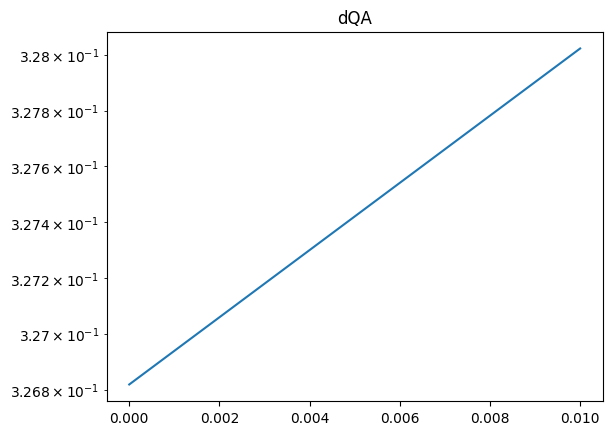

In [ ]:
plt.plot( *zip(*loss) )
plt.yscale('log')
plt.title('dQA')
plt.show()

In [ ]:
loss[-1]

(0.01, (0.3280228699938135+6.175615574477433e-16j))

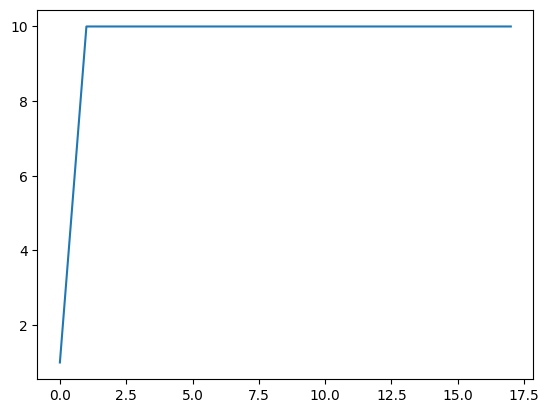

In [ ]:
plt.plot(cc)